In [1]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from numpy import cos
from math import log
from scipy.interpolate import interp1d
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from mpl_toolkits.mplot3d import Axes3D
from scipy.optimize import minimize_scalar
from scipy.optimize import minimize
from scipy.optimize import fsolve

In [2]:
def model(t, z, T_linha, T1, T2, omega1, phi1, R1, R2, omega2, phi2,
                   B_E, p_ME, p_ML, p_MP, tau_E, tau_P, c1, c2,
                   D1, b1, A, B, C, b2, tau_H, DD, Tmin, gamma, R_L,
                   N, M, E_M0, I_H0, I_M0):
    
    S_H, I_H, R_H, S_M, E_M, I_M = z
    
    # Funções de temperatura e chuva
    def Temp(t):
        return T1 * (1 + T2 * cos(omega1 * t - phi1))

    def Rain(t):
        return R1 * (1 + R2 * cos(omega2 * t - phi2))

    R_curr = Rain(t)
    T_curr = Temp(t)
    
    # Duração da fase de desenvolvimento das larvas
    def tau_L(Temp):
        return 1 / (c1 * Temp + c2)
    
    # Taxa diária de sobrevivência dos mosquitos
    def p(Temp):
        return np.exp(-1 / (A*Temp**2 + B*Temp + C))
    
    # Probabilidade de sobrevivência das larvas dependente de temperatura e chuva
    def p_LT(Temp):
        return np.exp(-(c1 * Temp + c2))
    
    def p_LR(Rain):
        return (4*p_ML/R_L**2) * Rain * (max(10^-5,R_L - Rain))
    
    def p_LRT(Rain,Temp):
        return p_LR(Rain)*p_LT(Temp)
    
    # Probabilidade de sobrevivência dos ovos e pupas dependente de chuva (Não definido previamente)
    def p_ER(Rain):
        return (4*p_ME/R_L**2) * Rain * (max(10^-5,R_L - Rain))
    
    # Probabilidade de sobrevivência dos ovos e pupas dependente de chuva (Não definido previamente)
    def p_PR(Rain):
        return (4*p_MP/R_L**2) * Rain * (max(10^-5,R_L - Rain))

    # Duração do ciclo esporogônico
    def tau_M(Temp):
        return DD / (max(10^-5,Temp - Tmin))
    
    tau_M_curr = tau_M(T_curr)

    # Taxa de infecção de expostos (1/Duração do ciclo esporogônico)
    def b3(tau_M, Temp):
        return 1/tau_M
    
    b3_curr = b3(tau_M_curr, T_curr)
    
    # Definindo a função de sobrevivência do mosquito
    def l_tau_M(tau_M, Temp):  
        p_T = p(Temp)
        return p_T**tau_M
    
    l_curr = l_tau_M(tau_M_curr, T_curr)

    # Definindo a taxa de mortalidade do mosquito
    def mu(Temp):
        return -log(p(Temp))
    
    mu_curr = mu(T_curr)
    
    # Calcula a taxa de picada e probabilidade de transmissão
    def a(Temp):
        return (max(10^-5, Temp - T_linha)) / D1
    
    a_curr = a(T_curr)
    
    def b(Rain,Temp):
        return B_E * p_ER(Rain) * p_LRT(Rain,Temp) * p_PR(Rain) / (tau_E + tau_L(Temp) + tau_P)
    
    b_curr = b(R_curr, T_curr)
    
    dShdt = -a_curr * b2 * (I_M / N) * S_H
    dIhdt = a_curr * b2 * (I_M / N) * S_H - gamma * I_H
    dRhdt = gamma * I_H
    
    dSmdt = b_curr - a_curr * b1 * (I_H / N) * S_M - mu_curr * S_M
    dEmdt = a_curr * b1 * (I_H / N) * S_M - mu_curr * E_M - b3_curr * E_M - l_curr * E_M
    dImdt = b3_curr * E_M - mu_curr * I_M
    
    return [dShdt, dIhdt, dRhdt, dSmdt, dEmdt, dImdt] 

In [3]:
T_linha = 24.4
T1= 26.4 
T2= 0.025
omega1= 0.017
phi1= -1.45

R1= 250.083 
R2= 0.565
omega2= 0.02
phi2=1.6

B_E=200
p_ME=0.9
p_ML=0.75
p_MP=0.85
tau_E=1
tau_P=1
c1=0.019
c2=-0.021

D1=36.5
b1=0.1

A=317.925
B=15
C=-48.78

b2=0.3
tau_H=10
DD=105
Tmin=14.5
gamma= 1/1825 
R_L = 400
N = 8558
M = 300000 
E_M0 = 50000
I_H0 = 1000 
I_M0 = 2500
if E_M0 is None:
        E_M0 = M / 100

S_H0 = N - I_H0
S_M0 = M - E_M0 - I_M0

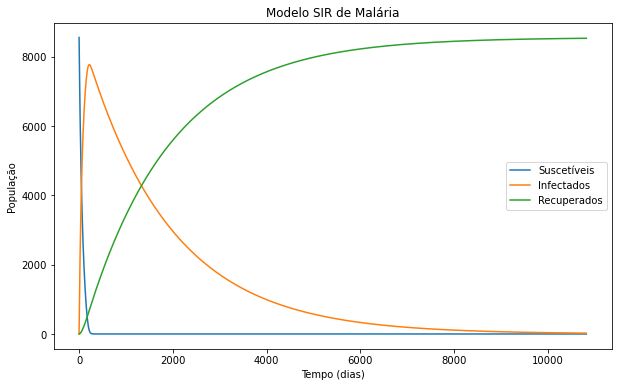

In [4]:
args = (T_linha, T1, T2, omega1, phi1, R1, R2, omega2, phi2,
                   B_E, p_ME, p_ML, p_MP, tau_E, tau_P, c1, c2,
                   D1, b1, 317.925, 15, -48.78, b2, tau_H, DD, Tmin, gamma, R_L,
                   N, M, E_M0, I_H0, I_M0)

t_eval = np.linspace(0, 10825, 1000)  # Avalia a solução em 1000 pontos entre 0 e 10825
sol = solve_ivp(model, [0, 10825], [N, 0, 0, S_M0, E_M0, I_M0], args=args, dense_output=True, t_eval=t_eval, method="DOP853")
#sol

times = sol.t
S_H, I_H, R_H, S_M, E_M, I_M = sol.y

plt.figure(figsize=(10, 6))
plt.plot(times, S_H, label='Suscetíveis')
plt.plot(times, I_H, label='Infectados')
plt.plot(times, R_H, label='Recuperados')

plt.xlabel('Tempo (dias)')
plt.ylabel('População')
plt.title('Modelo SIR de Malária')

plt.legend()

plt.show()

In [5]:
print(min(S_H))

2.8717313602016015e-305


In [6]:
print(min(I_H))

0.0


In [7]:
print(max(I_H))

7773.509415076746


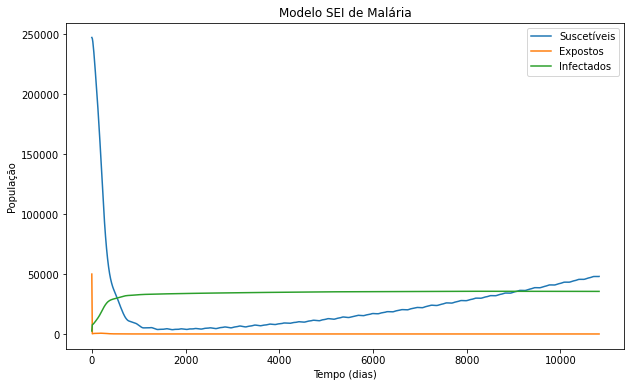

In [8]:
t_eval = np.linspace(0, 10825, 1000)  # Avalia a solução em 1000 pontos entre 0 e 10825
sol = solve_ivp(model, [0, 10825], [N, 0, 0, S_M0, E_M0, I_M0], args=args, dense_output=True, t_eval=t_eval, method="DOP853")
#sol

times = sol.t
S_H, I_H, R_H, S_M, E_M, I_M = sol.y

plt.figure(figsize=(10, 6))
plt.plot(times, S_M, label='Suscetíveis')
plt.plot(times, E_M, label='Expostos')
plt.plot(times, I_M, label='Infectados')

plt.xlabel('Tempo (dias)')
plt.ylabel('População')
plt.title('Modelo SEI de Malária')

plt.legend()

plt.show()

In [9]:
print(min(E_M))

0.4162285325010545


$\mathcal{R}_0$ do SIR:

$$\Big | \dfrac{ab_2}{\gamma}\Big |$$

$\mathcal{R}_0$ do SEI:

$$\Big | \dfrac{ab_1b_3}{(b_3+l+ \mu)\mu}\Big |$$

$\mathcal{R}_0$ do SIR/SEI:

$$\Big | \sqrt{\dfrac{a^2 b_1 b_2 b_3}{(b_3 +  l + \mu) \gamma \mu}}\Big |$$

In [10]:
def R0_sir(a, b2, gamma):
    return abs((a * b2) / gamma)
    
#R0_sir_curr = R0_sir(a_curr, b2, gamma)
    
def R0_sei(a, b1, b3, l, mu):
    return abs((a * b1 * b3) / ((b3 + l) * mu + mu** 2))
    
#R0_sei_curr = R0_sei(a_curr, b1, b3_curr, l_curr, mu_curr)
    
def R0_full(a, b1, b2, b3, gamma, l, mu):
    return abs(((a** 2 * b1 * b2 * b3) / (b3 * gamma * mu + gamma * l * mu + gamma * mu** 2))**(1/2))
    
#R0_curr = R0(a_curr, b1, b2, b3_curr, gamma, l_curr, mu_curr)

In [11]:
def calculate_initial_values(R_L, T_linha, Tmin, DD, D1, T1, T2, omega1, phi1, R1, R2, omega2, phi2,
                            p_ML, p_ME, p_MP, c1, c2, A, B, C, b1, b2, gamma):
    
    T0 = T1 * (1 + T2 * cos(omega1 * 0 - phi1))
    R0 = R1 * (1 + R2 * cos(omega2 * 0 - phi2))

    tau_L0 = 1 / (c1 * T0 + c2)

    p_LT0 = np.exp(-(c1 * T0 + c2))
    
    p_LR0 = (4 * p_ML / R_L**2) * R0 * (max(1e-5, R_L - R0))
    
    p_LRT0 = p_LR0 * p_LT0
    
    p_ER0 = (4 * p_ME / R_L**2) * R0 * (max(1e-5, R_L - R0))
    
    p_PR0 = (4 * p_MP / R_L**2) * R0 * (max(1e-5, R_L - R0))

    a0 = (max(1e-5, T0 - T_linha)) / D1
    b0 = B_E * p_ER0 * p_LRT0 * p_PR0 / (tau_E + tau_L0 + tau_P)

    tau_M0 = DD / (max(1e-5, T0 - Tmin))
    
    b30 =  1 / tau_M0
    
    p0 = np.exp(-1 / (A * T0**2 + B * T0 + C))
    l0 = p0 ** tau_M0

    mu0 = -log(p0)

    initial_R0_sir = R0_sir(a0, b2, gamma)
    initial_R0_sei = R0_sei(a0, b1, b30, l0, mu0)
    initial_R0_full = R0_full(a0, b1, b2, b30, gamma, l0, mu0)
    
    return initial_R0_sir, initial_R0_sei, initial_R0_full, a0

In [12]:
initial_R0_sir, initial_R0_sei, initial_R0_full, a0 = calculate_initial_values(R_L, T_linha, Tmin, DD, D1, 
                                                                           T1, T2, omega1, phi1, R1, R2, omega2, phi2,
                                                                           p_ML, p_ME, p_MP, c1, c2, A, B, C, b1, b2, gamma)

In [13]:
print(f'R0_sir = {initial_R0_sir} \nR0_sei = {initial_R0_sei}\nR0_acoplado = {initial_R0_full}\nTaxa de picadas = {a0}')

R0_sir = 31.192977416736966 
R0_sei = 130.26860810914607
R0_acoplado = 63.745319442750855
Taxa de picadas = 0.05697347473376614


In [14]:
x = 1/0.05697347473376614
x

17.5520275825363

Aproximadamente 1 picada por mosquito a cada 17.5 dias

In [15]:
initial_R0_sir, initial_R0_sei, initial_R0_full, a0 = calculate_initial_values(R_L, T_linha, Tmin, DD, D1, 
                                                                           T1, T2, omega1, phi1, R1, R2, omega2, phi2,
                                                                           p_ML, p_ME, p_MP, c1, c2, 100, B, C, b1, b2, gamma)

In [16]:
print(f'R0_sir = {initial_R0_sir} \nR0_sei = {initial_R0_sei}\nR0_acoplado = {initial_R0_full}\nTaxa de picadas = {a0}')

R0_sir = 31.192977416736966 
R0_sei = 41.1167636064345
R0_acoplado = 35.81276697805998
Taxa de picadas = 0.05697347473376614


In [17]:
initial_R0_sir, initial_R0_sei, initial_R0_full, a0 = calculate_initial_values(R_L, T_linha, Tmin, DD, D1, 
                                                                           T1, T2, omega1, phi1, R1, R2, omega2, phi2,
                                                                           p_ML, p_ME, p_MP, c1, c2, 5, B, C, b1, b2, gamma)

In [18]:
print(f'R0_sir = {initial_R0_sir} \nR0_sei = {initial_R0_sei}\nR0_acoplado = {initial_R0_full}\nTaxa de picadas = {a0}')

R0_sir = 31.192977416736966 
R0_sei = 2.2528205248149358
R0_acoplado = 8.382850335924756
Taxa de picadas = 0.05697347473376614


In [19]:
initial_R0_sir, initial_R0_sei, initial_R0_full, a0 = calculate_initial_values(R_L, 25.4, Tmin, DD, D1, 
                                                                           T1, T2, omega1, phi1, R1, R2, omega2, phi2,
                                                                           p_ML, p_ME, p_MP, c1, c2, 5, B, C, b1, b2, gamma)

In [20]:
print(f'R0_sir = {initial_R0_sir} \nR0_sei = {initial_R0_sei}\nR0_acoplado = {initial_R0_full}\nTaxa de picadas = {a0}')

R0_sir = 16.192977416736966 
R0_sei = 1.1694898949503956
R0_acoplado = 4.351726491639133
Taxa de picadas = 0.02957621445979354


In [21]:
initial_R0_sir, initial_R0_sei, initial_R0_full, a0 = calculate_initial_values(R_L, 25.4, Tmin, DD, D1, 
                                                                           T1, T2, omega1, phi1, R1, R2, omega2, phi2,
                                                                           p_ML, p_ME, p_MP, c1, c2, 50, B, C, b1, b2, gamma)

In [22]:
print(f'R0_sir = {initial_R0_sir} \nR0_sei = {initial_R0_sei}\nR0_acoplado = {initial_R0_full}\nTaxa de picadas = {a0}')

R0_sir = 16.192977416736966 
R0_sei = 10.726138710374322
R0_acoplado = 13.179078947554702
Taxa de picadas = 0.02957621445979354


Para evitar tempos de compilação muito longos para o código, foram omitidos os plots de modelos cujo $\mathcal{R}_0$ ficou muito maior que 1.

In [23]:
# args = (25.4, T1, T2, omega1, phi1, R1, R2, omega2, phi2,
#                    B_E, p_ME, p_ML, p_MP, tau_E, tau_P, c1, c2,
#                    D1, b1, 5, 15, -48.78, b2, tau_H, DD, Tmin, gamma, R_L,
#                    N, M, E_M0, I_H0, I_M0)

# t_eval = np.linspace(0, 10825, 1000)  # Avalia a solução em 1000 pontos entre 0 e 10825
# sol = solve_ivp(model, [0, 10825], [N, 0, 0, S_M0, E_M0, I_M0], args=args, dense_output=True, t_eval=t_eval, method="DOP853")
# #sol

# times = sol.t
# S_H, I_H, R_H, S_M, E_M, I_M = sol.y

# plt.figure(figsize=(10, 6))
# plt.plot(times, S_H, label='Suscetíveis')
# plt.plot(times, I_H, label='Infectados')
# plt.plot(times, R_H, label='Recuperados')

# plt.xlabel('Tempo (dias)')
# plt.ylabel('População')
# plt.title('Modelo SIR de Malária')

# plt.legend()

# plt.show()

In [24]:
# print(max(I_H))

In [25]:
# t_eval = np.linspace(0, 10825, 1000)  # Avalia a solução em 1000 pontos entre 0 e 10825
# sol = solve_ivp(model, [0, 10825], [N, 0, 0, S_M0, E_M0, I_M0], args=args, dense_output=True, t_eval=t_eval, method="DOP853")
# #sol

# times = sol.t
# S_H, I_H, R_H, S_M, E_M, I_M = sol.y

# plt.figure(figsize=(10, 6))
# plt.plot(times, S_M, label='Suscetíveis')
# plt.plot(times, E_M, label='Expostos')
# plt.plot(times, I_M, label='Infectados')

# plt.xlabel('Tempo (dias)')
# plt.ylabel('População')
# plt.title('Modelo SEI de Malária')

# plt.legend()

# plt.show()

In [26]:
initial_R0_sir, initial_R0_sei, initial_R0_full, a0 = calculate_initial_values(R_L, 25.4, Tmin, DD, D1, 
                                                                           T1, T2, omega1, phi1, R1, R2, omega2, phi2,
                                                                           p_ML, p_ME, p_MP, c1, c2, 2.5, B, C, b1, b2, gamma)

In [27]:
print(f'R0_sir = {initial_R0_sir} \nR0_sei = {initial_R0_sei}\nR0_acoplado = {initial_R0_full}\nTaxa de picadas = {a0}')

R0_sir = 16.192977416736966 
R0_sei = 0.6385658282103062
R0_acoplado = 3.2156308922681758
Taxa de picadas = 0.02957621445979354


In [28]:
initial_R0_sir, initial_R0_sei, initial_R0_full, a0 = calculate_initial_values(R_L, 25.4, Tmin, DD, D1, 
                                                                           T1, T2, omega1, phi1, R1, R2, omega2, phi2,
                                                                           p_ML, p_ME, p_MP, c1, c2, 2.5, 5, C, b1, b2, gamma)

In [29]:
print(f'R0_sir = {initial_R0_sir} \nR0_sei = {initial_R0_sei}\nR0_acoplado = {initial_R0_full}\nTaxa de picadas = {a0}')

R0_sir = 16.192977416736966 
R0_sei = 0.558364552963015
R0_acoplado = 3.006922778595508
Taxa de picadas = 0.02957621445979354


In [30]:
initial_R0_sir, initial_R0_sei, initial_R0_full, a0 = calculate_initial_values(R_L, 25.9, Tmin, DD, D1, 
                                                                           T1, T2, omega1, phi1, R1, R2, omega2, phi2,
                                                                           p_ML, p_ME, p_MP, c1, c2, 2.5, 5, C, b1, b2, gamma)

In [31]:
print(f'R0_sir = {initial_R0_sir} \nR0_sei = {initial_R0_sei}\nR0_acoplado = {initial_R0_full}\nTaxa de picadas = {a0}')

R0_sir = 8.692977416736962 
R0_sei = 0.2997503377110258
R0_acoplado = 1.6142251752408106
Taxa de picadas = 0.015877584322807236


In [32]:
# args = (25.9, T1, T2, omega1, phi1, R1, R2, omega2, phi2,
#                    B_E, p_ME, p_ML, p_MP, tau_E, tau_P, c1, c2,
#                    D1, b1, 2.5, 5, -48.78, b2, tau_H, DD, Tmin, gamma, R_L,
#                    N, M, E_M0, I_H0, I_M0)

# t_eval = np.linspace(0, 10825, 1000)  # Avalia a solução em 1000 pontos entre 0 e 10825
# sol = solve_ivp(model, [0, 10825], [N, 0, 0, S_M0, E_M0, I_M0], args=args, dense_output=True, t_eval=t_eval, method="DOP853")
# #sol

# times = sol.t
# S_H, I_H, R_H, S_M, E_M, I_M = sol.y

# plt.figure(figsize=(10, 6))
# plt.plot(times, S_H, label='Suscetíveis')
# plt.plot(times, I_H, label='Infectados')
# plt.plot(times, R_H, label='Recuperados')

# plt.xlabel('Tempo (dias)')
# plt.ylabel('População')
# plt.title('Modelo SIR de Malária')

# plt.legend()

# plt.show()

In [33]:
# t_eval = np.linspace(0, 10825, 1000)  # Avalia a solução em 1000 pontos entre 0 e 10825
# sol = solve_ivp(model, [0, 10825], [N, 0, 0, S_M0, E_M0, I_M0], args=args, dense_output=True, t_eval=t_eval, method="DOP853")
# #sol

# times = sol.t
# S_H, I_H, R_H, S_M, E_M, I_M = sol.y

# plt.figure(figsize=(10, 6))
# plt.plot(times, S_M, label='Suscetíveis')
# plt.plot(times, E_M, label='Expostos')
# plt.plot(times, I_M, label='Infectados')

# plt.xlabel('Tempo (dias)')
# plt.ylabel('População')
# plt.title('Modelo SEI de Malária')

# plt.legend()

# plt.show()

In [34]:
initial_R0_sir, initial_R0_sei, initial_R0_full, a0 = calculate_initial_values(R_L, 25.9, Tmin, DD, D1, 
                                                                           T1, T2, omega1, phi1, R1, R2, omega2, phi2,
                                                                           p_ML, p_ME, p_MP, c1, c2, -0.03, 1.31, -4.4, b1, b2, gamma)

In [35]:
print(f'R0_sir = {initial_R0_sir} \nR0_sei = {initial_R0_sei}\nR0_acoplado = {initial_R0_full}\nTaxa de picadas = {a0}')

R0_sir = 8.692977416736962 
R0_sei = 0.002747998096419893
R0_acoplado = 0.15455835594821232
Taxa de picadas = 0.015877584322807236


In [36]:
# args = (25.9, T1, T2, omega1, phi1, R1, R2, omega2, phi2,
#                    B_E, p_ME, p_ML, p_MP, tau_E, tau_P, c1, c2,
#                    D1, b1, -0.03, 1.31, -4.4, b2, tau_H, DD, Tmin, gamma, R_L,
#                    N, M, E_M0, I_H0, I_M0)

# t_eval = np.linspace(0, 10825, 1000)  # Avalia a solução em 1000 pontos entre 0 e 10825
# sol = solve_ivp(model, [0, 10825], [N, 0, 0, S_M0, E_M0, I_M0], args=args, dense_output=True, t_eval=t_eval, method="DOP853")
# #sol

# times = sol.t
# S_H, I_H, R_H, S_M, E_M, I_M = sol.y

# plt.figure(figsize=(10, 6))
# plt.plot(times, S_H, label='Suscetíveis')
# plt.plot(times, I_H, label='Infectados')
# plt.plot(times, R_H, label='Recuperados')

# plt.xlabel('Tempo (dias)')
# plt.ylabel('População')
# plt.title('Modelo SIR de Malária')

# plt.legend()

# plt.show()

In [37]:
# t_eval = np.linspace(0, 10825, 1000)  # Avalia a solução em 1000 pontos entre 0 e 10825
# sol = solve_ivp(model, [0, 10825], [N, 0, 0, S_M0, E_M0, I_M0], args=args, dense_output=True, t_eval=t_eval, method="DOP853")
# #sol

# times = sol.t
# S_H, I_H, R_H, S_M, E_M, I_M = sol.y

# plt.figure(figsize=(10, 6))
# plt.plot(times, S_M, label='Suscetíveis')
# plt.plot(times, E_M, label='Expostos')
# plt.plot(times, I_M, label='Infectados')

# plt.xlabel('Tempo (dias)')
# plt.ylabel('População')
# plt.title('Modelo SEI de Malária')

# plt.legend()

# plt.show()

In [38]:
initial_R0_sir, initial_R0_sei, initial_R0_full, a0 = calculate_initial_values(R_L, 25.9, Tmin, DD, D1, 
                                                                           T1, T2, omega1, phi1, R1, R2, omega2, phi2,
                                                                           p_ML, p_ME, p_MP, c1, c2, 1, 1.31, -4.4, b1, b2, gamma)

In [39]:
print(f'R0_sir = {initial_R0_sir} \nR0_sei = {initial_R0_sei}\nR0_acoplado = {initial_R0_full}\nTaxa de picadas = {a0}')

R0_sir = 8.692977416736962 
R0_sei = 0.12006909251254835
R0_acoplado = 1.0216447081347233
Taxa de picadas = 0.015877584322807236


In [40]:
# args = (25.9, T1, T2, omega1, phi1, R1, R2, omega2, phi2,
#                    B_E, p_ME, p_ML, p_MP, tau_E, tau_P, c1, c2,
#                    D1, b1, 1, 1.31, -4.4, b2, tau_H, DD, Tmin, gamma, R_L,
#                    N, M, E_M0, I_H0, I_M0)

# t_eval = np.linspace(0, 10825, 1000)  # Avalia a solução em 1000 pontos entre 0 e 10825
# sol = solve_ivp(model, [0, 10825], [N, 0, 0, S_M0, E_M0, I_M0], args=args, dense_output=True, t_eval=t_eval, method="DOP853")
# #sol

# times = sol.t
# S_H, I_H, R_H, S_M, E_M, I_M = sol.y

# plt.figure(figsize=(10, 6))
# plt.plot(times, S_H, label='Suscetíveis')
# plt.plot(times, I_H, label='Infectados')
# plt.plot(times, R_H, label='Recuperados')

# plt.xlabel('Tempo (dias)')
# plt.ylabel('População')
# plt.title('Modelo SIR de Malária')

# plt.legend()

# plt.show()

In [41]:
# t_eval = np.linspace(0, 10825, 1000)  # Avalia a solução em 1000 pontos entre 0 e 10825
# sol = solve_ivp(model, [0, 10825], [N, 0, 0, S_M0, E_M0, I_M0], args=args, dense_output=True, t_eval=t_eval, method="DOP853")
# #sol

# times = sol.t
# S_H, I_H, R_H, S_M, E_M, I_M = sol.y

# plt.figure(figsize=(10, 6))
# plt.plot(times, S_M, label='Suscetíveis')
# plt.plot(times, E_M, label='Expostos')
# plt.plot(times, I_M, label='Infectados')

# plt.xlabel('Tempo (dias)')
# plt.ylabel('População')
# plt.title('Modelo SEI de Malária')

# plt.legend()

# plt.show()

In [42]:
initial_R0_sir, initial_R0_sei, initial_R0_full, a0 = calculate_initial_values(R_L, 25.2, Tmin, DD, 55, 
                                                                           T1, T2, omega1, phi1, R1, R2, omega2, phi2,
                                                                           p_ML, p_ME, p_MP, c1, c2, 5, B, C, b1, b2, gamma)

In [43]:
print(f'R0_sir = {initial_R0_sir} \nR0_sei = {initial_R0_sei}\nR0_acoplado = {initial_R0_full}\nTaxa de picadas = {a0}')

R0_sir = 12.73715774019816 
R0_sei = 0.919903541158192
R0_acoplado = 3.4230040183293333
Taxa de picadas = 0.023264215050590245


In [44]:
# args = (25.2, T1, T2, omega1, phi1, R1, R2, omega2, phi2,
#                    B_E, p_ME, p_ML, p_MP, tau_E, tau_P, c1, c2,
#                    55, b1, 5, 15, -48.78, b2, tau_H, DD, Tmin, gamma, R_L,
#                    N, M, E_M0, I_H0, I_M0)

# t_eval = np.linspace(0, 10825, 1000)  # Avalia a solução em 1000 pontos entre 0 e 10825
# sol = solve_ivp(model, [0, 10825], [N, 0, 0, S_M0, E_M0, I_M0], args=args, dense_output=True, t_eval=t_eval, method="DOP853")
# #sol

# times = sol.t
# S_H, I_H, R_H, S_M, E_M, I_M = sol.y

# plt.figure(figsize=(10, 6))
# plt.plot(times, S_H, label='Suscetíveis')
# plt.plot(times, I_H, label='Infectados')
# plt.plot(times, R_H, label='Recuperados')

# plt.xlabel('Tempo (dias)')
# plt.ylabel('População')
# plt.title('Modelo SIR de Malária')

# plt.legend()

# plt.show()

In [45]:
# t_eval = np.linspace(0, 10825, 1000)  # Avalia a solução em 1000 pontos entre 0 e 10825
# sol = solve_ivp(model, [0, 10825], [N, 0, 0, S_M0, E_M0, I_M0], args=args, dense_output=True, t_eval=t_eval, method="DOP853")
# #sol

# times = sol.t
# S_H, I_H, R_H, S_M, E_M, I_M = sol.y

# plt.figure(figsize=(10, 6))
# plt.plot(times, S_M, label='Suscetíveis')
# plt.plot(times, E_M, label='Expostos')
# plt.plot(times, I_M, label='Infectados')

# plt.xlabel('Tempo (dias)')
# plt.ylabel('População')
# plt.title('Modelo SEI de Malária')

# plt.legend()

# plt.show()

In [46]:
initial_R0_sir, initial_R0_sei, initial_R0_full, a0 = calculate_initial_values(R_L, T_linha, Tmin, DD, D1, 
                                                                           T1, T2, omega1, phi1, R1, R2, omega2, phi2,
                                                                           p_ML, p_ME, p_MP, c1, c2, A, B, C, b1, b2, gamma)

In [47]:
print(f'R0_sir = {initial_R0_sir} \nR0_sei = {initial_R0_sei}\nR0_acoplado = {initial_R0_full}\nTaxa de picadas = {a0}')

R0_sir = 31.192977416736966 
R0_sei = 130.26860810914607
R0_acoplado = 63.745319442750855
Taxa de picadas = 0.05697347473376614


In [48]:
gamma

1/1825

In [49]:
initial_R0_sir, initial_R0_sei, initial_R0_full, a0 = calculate_initial_values(R_L, T_linha, Tmin, DD, D1, 
                                                                           T1, T2, omega1, phi1, R1, R2, omega2, phi2,
                                                                           p_ML, p_ME, p_MP, c1, c2, A, B, C, b1, b2, 1/1095)

In [50]:
print(f'R0_sir = {initial_R0_sir} \nR0_sei = {initial_R0_sei}\nR0_acoplado = {initial_R0_full}\nTaxa de picadas = {a0}')

R0_sir = 18.715786450042177 
R0_sei = 130.26860810914607
R0_acoplado = 49.37691212008919
Taxa de picadas = 0.05697347473376614


In [51]:
initial_R0_sir, initial_R0_sei, initial_R0_full, a0 = calculate_initial_values(R_L, T_linha, Tmin, DD, D1, 
                                                                           T1, T2, omega1, phi1, R1, R2, omega2, phi2,
                                                                           p_ML, p_ME, p_MP, c1, c2, 5, B, C, b1, b2, 1/1095)

In [52]:
print(f'R0_sir = {initial_R0_sir} \nR0_sei = {initial_R0_sei}\nR0_acoplado = {initial_R0_full}\nTaxa de picadas = {a0}')

R0_sir = 18.715786450042177 
R0_sei = 2.2528205248149358
R0_acoplado = 6.493327948957167
Taxa de picadas = 0.05697347473376614


In [53]:
initial_R0_sir, initial_R0_sei, initial_R0_full, a0 = calculate_initial_values(R_L, T_linha, Tmin, DD, 40, 
                                                                           T1, T2, omega1, phi1, R1, R2, omega2, phi2,
                                                                           p_ML, p_ME, p_MP, c1, c2, 5, B, C, b1, b2, 1/1095)

In [54]:
print(f'R0_sir = {initial_R0_sir} \nR0_sei = {initial_R0_sei}\nR0_acoplado = {initial_R0_full}\nTaxa de picadas = {a0}')

R0_sir = 17.078155135663486 
R0_sei = 2.0556987288936295
R0_acoplado = 5.925161753423416
Taxa de picadas = 0.051988295694561606


In [55]:
T_linha

24.4000000000000

In [56]:
initial_R0_sir, initial_R0_sei, initial_R0_full, a0 = calculate_initial_values(R_L, 25.4, Tmin, DD, 40, 
                                                                           T1, T2, omega1, phi1, R1, R2, omega2, phi2,
                                                                           p_ML, p_ME, p_MP, c1, c2, 5, B, C, b1, b2, 1/1095)

In [57]:
print(f'R0_sir = {initial_R0_sir} \nR0_sei = {initial_R0_sei}\nR0_acoplado = {initial_R0_full}\nTaxa de picadas = {a0}')

R0_sir = 8.865655135663486 
R0_sei = 1.0671595291422362
R0_acoplado = 3.0758849718596593
Taxa de picadas = 0.026988295694561605


In [58]:
b2

0.300000000000000

In [59]:
initial_R0_sir, initial_R0_sei, initial_R0_full, a0 = calculate_initial_values(R_L, 25.4, Tmin, DD, 40, 
                                                                           T1, T2, omega1, phi1, R1, R2, omega2, phi2,
                                                                           p_ML, p_ME, p_MP, c1, c2, 5, B, C, b1, 0.25, 1/1095)

In [60]:
print(f'R0_sir = {initial_R0_sir} \nR0_sei = {initial_R0_sei}\nR0_acoplado = {initial_R0_full}\nTaxa de picadas = {a0}')

R0_sir = 7.38804594638624 
R0_sei = 1.0671595291422362
R0_acoplado = 2.807885972297797
Taxa de picadas = 0.026988295694561605


In [61]:
initial_R0_sir, initial_R0_sei, initial_R0_full, a0 = calculate_initial_values(R_L, 25.7, Tmin, DD, 40, 
                                                                           T1, T2, omega1, phi1, R1, R2, omega2, phi2,
                                                                           p_ML, p_ME, p_MP, c1, c2, 10, B, C, b1, 0.25, 1/1095)

In [62]:
print(f'R0_sir = {initial_R0_sir} \nR0_sei = {initial_R0_sei}\nR0_acoplado = {initial_R0_full}\nTaxa de picadas = {a0}')

R0_sir = 5.334920946386234 
R0_sei = 1.4702693282469035
R0_acoplado = 2.800673246934319
Taxa de picadas = 0.019488295694561585


In [63]:
initial_R0_sir, initial_R0_sei, initial_R0_full, a0 = calculate_initial_values(R_L, 25.9, Tmin, DD, 40, 
                                                                           T1, T2, omega1, phi1, R1, R2, omega2, phi2,
                                                                           p_ML, p_ME, p_MP, c1, c2, 15, B, C, b1, 0.25, 1/1095)

In [64]:
print(f'R0_sir = {initial_R0_sir} \nR0_sei = {initial_R0_sei}\nR0_acoplado = {initial_R0_full}\nTaxa de picadas = {a0}')

R0_sir = 3.966170946386239 
R0_sei = 1.6132117940850181
R0_acoplado = 2.5294809246301146
Taxa de picadas = 0.014488295694561604


In [65]:
initial_R0_sir, initial_R0_sei, initial_R0_full, a0 = calculate_initial_values(R_L, 26.1, Tmin, DD, 40, 
                                                                           T1, T2, omega1, phi1, R1, R2, omega2, phi2,
                                                                           p_ML, p_ME, p_MP, c1, c2, 20, B, C, b1, 0.25, 1/1095)

In [66]:
print(f'R0_sir = {initial_R0_sir} \nR0_sei = {initial_R0_sei}\nR0_acoplado = {initial_R0_full}\nTaxa de picadas = {a0}')

R0_sir = 2.5974209463862197 
R0_sei = 1.397132754387386
R0_acoplado = 1.904978183898196
Taxa de picadas = 0.009488295694561532


In [67]:
initial_R0_sir, initial_R0_sei, initial_R0_full, a0 = calculate_initial_values(R_L, 26.1, Tmin, DD, 40, 
                                                                           T1, T2, omega1, phi1, R1, R2, omega2, phi2,
                                                                           p_ML, p_ME, p_MP, c1, c2, 20, B, C, b1, 0.2, 1/1095)

In [68]:
print(f'R0_sir = {initial_R0_sir} \nR0_sei = {initial_R0_sei}\nR0_acoplado = {initial_R0_full}\nTaxa de picadas = {a0}')

R0_sir = 2.0779367571089757 
R0_sei = 1.397132754387386
R0_acoplado = 1.7038642859401845
Taxa de picadas = 0.009488295694561532


In [69]:
initial_R0_sir, initial_R0_sei, initial_R0_full, a0 = calculate_initial_values(R_L, 26.2, Tmin, DD, 40, 
                                                                           T1, T2, omega1, phi1, R1, R2, omega2, phi2,
                                                                           p_ML, p_ME, p_MP, c1, c2, 25, B, C, b1, 0.2, 1/1095)

In [70]:
print(f'R0_sir = {initial_R0_sir} \nR0_sei = {initial_R0_sei}\nR0_acoplado = {initial_R0_full}\nTaxa de picadas = {a0}')

R0_sir = 1.5304367571089874 
R0_sei = 1.2799075993752909
R0_acoplado = 1.3995776633638697
Taxa de picadas = 0.006988295694561586


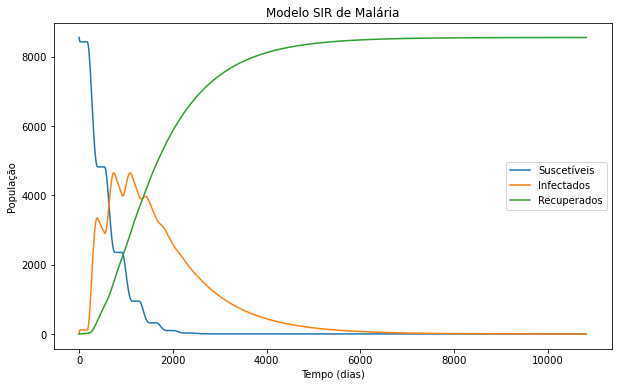

In [71]:
args = (26.2, T1, T2, omega1, phi1, R1, R2, omega2, phi2,
                   B_E, p_ME, p_ML, p_MP, tau_E, tau_P, c1, c2,
                   40, b1, 25, B, C, 0.2, tau_H, DD, Tmin, 1/1095, R_L,
                   N, M, E_M0, I_H0, I_M0)

t_eval = np.linspace(0, 10825, 1000)  # Avalia a solução em 1000 pontos entre 0 e 10825
sol = solve_ivp(model, [0, 10825], [N, 0, 0, S_M0, E_M0, I_M0], args=args, dense_output=True, t_eval=t_eval, method="DOP853")
#sol

times = sol.t
S_H, I_H, R_H, S_M, E_M, I_M = sol.y

plt.figure(figsize=(10, 6))
plt.plot(times, S_H, label='Suscetíveis')
plt.plot(times, I_H, label='Infectados')
plt.plot(times, R_H, label='Recuperados')

plt.xlabel('Tempo (dias)')
plt.ylabel('População')
plt.title('Modelo SIR de Malária')

plt.legend()

plt.show()

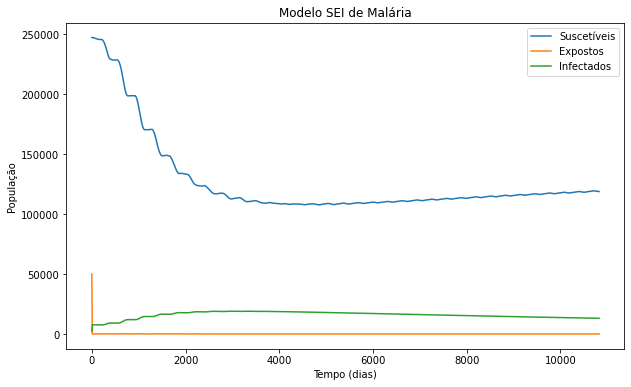

In [72]:
t_eval = np.linspace(0, 10825, 1000)  # Avalia a solução em 1000 pontos entre 0 e 10825
sol = solve_ivp(model, [0, 10825], [N, 0, 0, S_M0, E_M0, I_M0], args=args, dense_output=True, t_eval=t_eval, method="DOP853")
#sol

times = sol.t
S_H, I_H, R_H, S_M, E_M, I_M = sol.y

plt.figure(figsize=(10, 6))
plt.plot(times, S_M, label='Suscetíveis')
plt.plot(times, E_M, label='Expostos')
plt.plot(times, I_M, label='Infectados')

plt.xlabel('Tempo (dias)')
plt.ylabel('População')
plt.title('Modelo SEI de Malária')

plt.legend()

plt.show()

In [73]:
initial_R0_sir, initial_R0_sei, initial_R0_full, a0 = calculate_initial_values(R_L, 25.6, Tmin, DD, 40, 
                                                                           T1, T2, omega1, phi1, R1, R2, omega2, phi2,
                                                                           p_ML, p_ME, p_MP, c1, c2, 25, B, C, b1, 0.2, 1/1095)

In [74]:
print(f'R0_sir = {initial_R0_sir} \nR0_sei = {initial_R0_sei}\nR0_acoplado = {initial_R0_full}\nTaxa de picadas = {a0}')

R0_sir = 4.815436757108976 
R0_sei = 4.027160267228196
R0_acoplado = 4.403695672679876
Taxa de picadas = 0.02198829569456153


In [75]:
initial_R0_sir, initial_R0_sei, initial_R0_full, a0 = calculate_initial_values(R_L, 25.6, Tmin, DD, 40, 
                                                                           T1, T2, omega1, phi1, R1, R2, omega2, phi2,
                                                                           p_ML, p_ME, p_MP, c1, c2, 15, B, C, b1, 0.2, 1/1095)

In [76]:
print(f'R0_sir = {initial_R0_sir} \nR0_sei = {initial_R0_sei}\nR0_acoplado = {initial_R0_full}\nTaxa de picadas = {a0}')

R0_sir = 4.815436757108976 
R0_sei = 2.4483057699885524
R0_acoplado = 3.433607665043412
Taxa de picadas = 0.02198829569456153


In [77]:
initial_R0_sir, initial_R0_sei, initial_R0_full, a0 = calculate_initial_values(R_L, 25.6, Tmin, DD, 45, 
                                                                           T1, T2, omega1, phi1, R1, R2, omega2, phi2,
                                                                           p_ML, p_ME, p_MP, c1, c2, 15, B, C, b1, 0.2, 1/1095)

In [78]:
print(f'R0_sir = {initial_R0_sir} \nR0_sei = {initial_R0_sei}\nR0_acoplado = {initial_R0_full}\nTaxa de picadas = {a0}')

R0_sir = 4.2803882285413115 
R0_sei = 2.17627179554538
R0_acoplado = 3.052095702260811
Taxa de picadas = 0.01954515172849914


In [79]:
initial_R0_sir, initial_R0_sei, initial_R0_full, a0 = calculate_initial_values(R_L, 25.6, Tmin, DD, 55, 
                                                                           T1, T2, omega1, phi1, R1, R2, omega2, phi2,
                                                                           p_ML, p_ME, p_MP, c1, c2, 15, B, C, b1, 0.2, 1/1095)

In [80]:
print(f'R0_sir = {initial_R0_sir} \nR0_sei = {initial_R0_sei}\nR0_acoplado = {initial_R0_full}\nTaxa de picadas = {a0}')

R0_sir = 3.5021358233519826 
R0_sei = 1.7805860145371295
R0_acoplado = 2.497169210940663
Taxa de picadas = 0.015991487777862932


In [81]:
initial_R0_sir, initial_R0_sei, initial_R0_full, a0 = calculate_initial_values(R_L, 25.6, Tmin, DD, 55, 
                                                                           T1, T2, omega1, phi1, R1, R2, omega2, phi2,
                                                                           p_ML, p_ME, p_MP, c1, c2, 15, B, C, b1, 0.2, 1/365)

In [82]:
print(f'R0_sir = {initial_R0_sir} \nR0_sei = {initial_R0_sei}\nR0_acoplado = {initial_R0_full}\nTaxa de picadas = {a0}')

R0_sir = 1.167378607783994 
R0_sei = 1.7805860145371295
R0_acoplado = 1.4417413161486372
Taxa de picadas = 0.015991487777862932


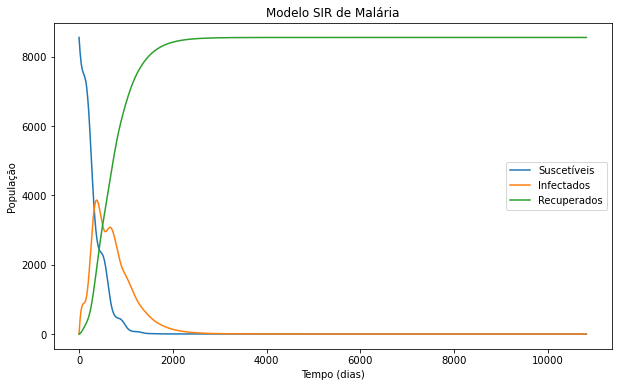

In [83]:
args = (25.6, T1, T2, omega1, phi1, R1, R2, omega2, phi2,
                   B_E, p_ME, p_ML, p_MP, tau_E, tau_P, c1, c2,
                   55, b1, 15, B, C, 0.2, tau_H, DD, Tmin, 1/365, R_L,
                   N, M, E_M0, I_H0, I_M0)

t_eval = np.linspace(0, 10825, 1000)  # Avalia a solução em 1000 pontos entre 0 e 10825
sol = solve_ivp(model, [0, 10825], [N, 0, 0, S_M0, E_M0, I_M0], args=args, dense_output=True, t_eval=t_eval, method="DOP853")
#sol

times = sol.t
S_H, I_H, R_H, S_M, E_M, I_M = sol.y

plt.figure(figsize=(10, 6))
plt.plot(times, S_H, label='Suscetíveis')
plt.plot(times, I_H, label='Infectados')
plt.plot(times, R_H, label='Recuperados')

plt.xlabel('Tempo (dias)')
plt.ylabel('População')
plt.title('Modelo SIR de Malária')

plt.legend()

plt.show()

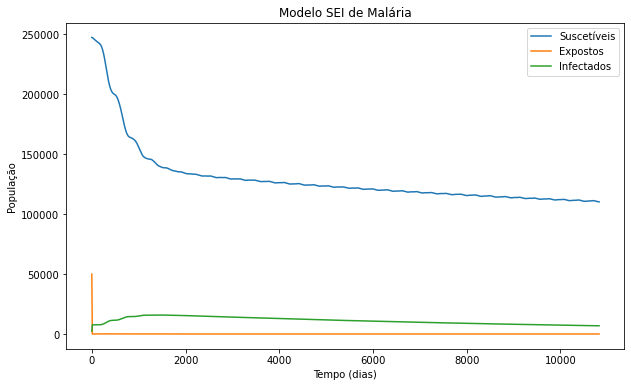

In [84]:
t_eval = np.linspace(0, 10825, 1000)  # Avalia a solução em 1000 pontos entre 0 e 10825
sol = solve_ivp(model, [0, 10825], [N, 0, 0, S_M0, E_M0, I_M0], args=args, dense_output=True, t_eval=t_eval, method="DOP853")
#sol

times = sol.t
S_H, I_H, R_H, S_M, E_M, I_M = sol.y

plt.figure(figsize=(10, 6))
plt.plot(times, S_M, label='Suscetíveis')
plt.plot(times, E_M, label='Expostos')
plt.plot(times, I_M, label='Infectados')

plt.xlabel('Tempo (dias)')
plt.ylabel('População')
plt.title('Modelo SEI de Malária')

plt.legend()

plt.show()

In [85]:
initial_R0_sir, initial_R0_sei, initial_R0_full, a0 = calculate_initial_values(R_L, 25.6, Tmin, DD, 55, 
                                                                           T1, T2, omega1, phi1, R1, R2, omega2, phi2,
                                                                           p_ML, p_ME, p_MP, c1, c2, 15, B, C, b1, 0.2, 1/365)

In [86]:
print(f'R0_sir = {initial_R0_sir} \nR0_sei = {initial_R0_sei}\nR0_acoplado = {initial_R0_full}\nTaxa de picadas = {a0}')

R0_sir = 1.167378607783994 
R0_sei = 1.7805860145371295
R0_acoplado = 1.4417413161486372
Taxa de picadas = 0.015991487777862932


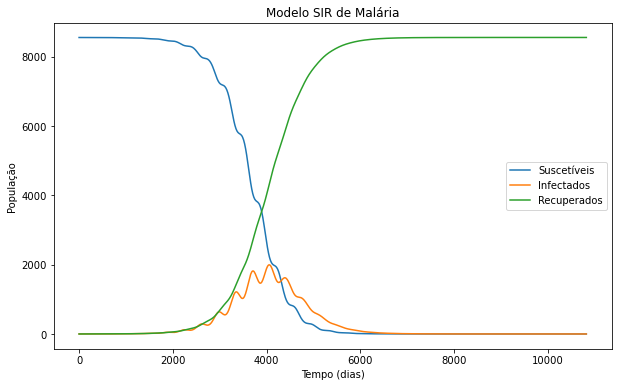

In [87]:
args = (25.6, T1, T2, omega1, phi1, R1, R2, omega2, phi2,
                   B_E, p_ME, p_ML, p_MP, tau_E, tau_P, c1, c2,
                   55, b1, 15, B, C, 0.2, tau_H, DD, Tmin, 1/365, R_L,
                   N, M, E_M0, I_H0, I_M0)

t_eval = np.linspace(0, 10825, 1000)  # Avalia a solução em 1000 pontos entre 0 e 10825
sol = solve_ivp(model, [0, 10825], [N-1, 1, 0, M-1, 1, 0], args=args, dense_output=True, t_eval=t_eval, method="DOP853")
#sol

times = sol.t
S_H, I_H, R_H, S_M, E_M, I_M = sol.y

plt.figure(figsize=(10, 6))
plt.plot(times, S_H, label='Suscetíveis')
plt.plot(times, I_H, label='Infectados')
plt.plot(times, R_H, label='Recuperados')

plt.xlabel('Tempo (dias)')
plt.ylabel('População')
plt.title('Modelo SIR de Malária')

plt.legend()

plt.show()

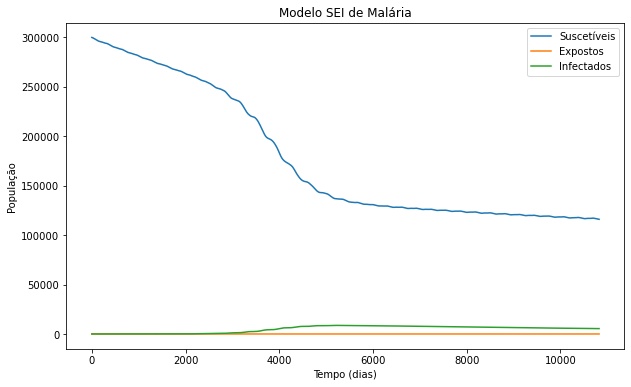

In [88]:
t_eval = np.linspace(0, 10825, 1000)  # Avalia a solução em 1000 pontos entre 0 e 10825
sol = solve_ivp(model, [0, 10825], [N-1, 1, 0, M-1, 1, 0], args=args, dense_output=True, t_eval=t_eval, method="DOP853")
#sol

times = sol.t
S_H, I_H, R_H, S_M, E_M, I_M = sol.y

plt.figure(figsize=(10, 6))
plt.plot(times, S_M, label='Suscetíveis')
plt.plot(times, E_M, label='Expostos')
plt.plot(times, I_M, label='Infectados')

plt.xlabel('Tempo (dias)')
plt.ylabel('População')
plt.title('Modelo SEI de Malária')

plt.legend()

plt.show()

In [89]:
initial_R0_sir, initial_R0_sei, initial_R0_full, a0 = calculate_initial_values(R_L, 25.6, Tmin, DD, 60, 
                                                                           T1, T2, omega1, phi1, R1, R2, omega2, phi2,
                                                                           p_ML, p_ME, p_MP, c1, c2, 15, B, C, b1, 0.2, 1/365)

In [90]:
print(f'R0_sir = {initial_R0_sir} \nR0_sei = {initial_R0_sei}\nR0_acoplado = {initial_R0_full}\nTaxa de picadas = {a0}')

R0_sir = 1.070097057135328 
R0_sei = 1.6322038466590354
R0_acoplado = 1.321596206469584
Taxa de picadas = 0.014658863796374355


In [91]:
initial_R0_sir, initial_R0_sei, initial_R0_full, a0 = calculate_initial_values(R_L, 25.6, Tmin, DD, 36.5, 
                                                                           T1, T2, omega1, phi1, R1, R2, omega2, phi2,
                                                                           p_ML, p_ME, p_MP, c1, c2, 15, B, C, 0.04, 0.09, 1/365)

In [92]:
print(f'R0_sir = {initial_R0_sir} \nR0_sei = {initial_R0_sei}\nR0_acoplado = {initial_R0_full}\nTaxa de picadas = {a0}')

R0_sir = 0.7915786450042152 
R0_sei = 1.0732299265703247
R0_acoplado = 0.9217081376729355
Taxa de picadas = 0.02409676240499894


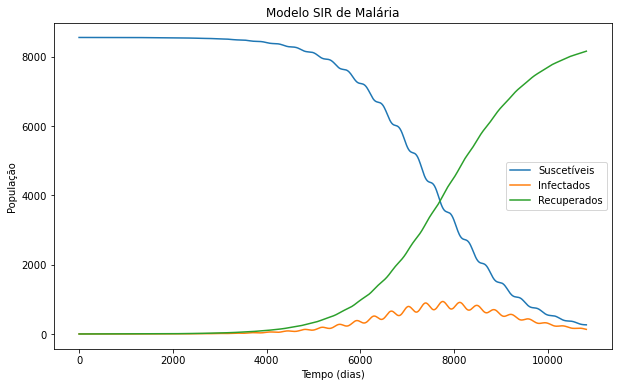

In [93]:
args = (25.6, T1, T2, omega1, phi1, R1, R2, omega2, phi2,
                   B_E, p_ME, p_ML, p_MP, tau_E, tau_P, c1, c2,
                   36.5, 0.04, 15, B, C, 0.09, tau_H, DD, Tmin, 1/365, R_L,
                   N, M, E_M0, I_H0, I_M0)

t_eval = np.linspace(0, 10825, 1000)  # Avalia a solução em 1000 pontos entre 0 e 10825
sol = solve_ivp(model, [0, 10825], [N-1, 1, 0, M-1, 1, 0], args=args, dense_output=True, t_eval=t_eval, method="DOP853")
#sol

times = sol.t
S_H, I_H, R_H, S_M, E_M, I_M = sol.y

plt.figure(figsize=(10, 6))
plt.plot(times, S_H, label='Suscetíveis')
plt.plot(times, I_H, label='Infectados')
plt.plot(times, R_H, label='Recuperados')

plt.xlabel('Tempo (dias)')
plt.ylabel('População')
plt.title('Modelo SIR de Malária')

plt.legend()

plt.show()

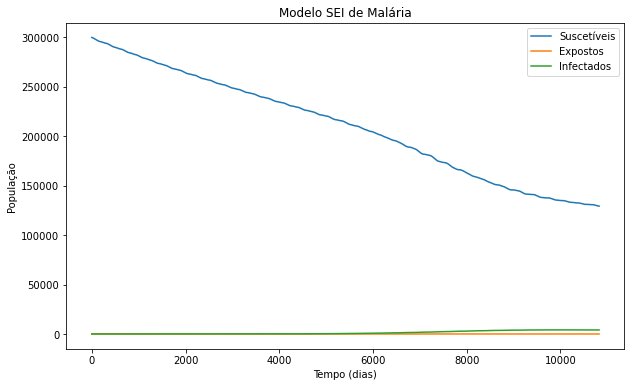

In [94]:
t_eval = np.linspace(0, 10825, 1000)  # Avalia a solução em 1000 pontos entre 0 e 10825
sol = solve_ivp(model, [0, 10825], [N-1, 1, 0, M-1, 1, 0], args=args, dense_output=True, t_eval=t_eval, method="DOP853")
#sol

times = sol.t
S_H, I_H, R_H, S_M, E_M, I_M = sol.y

plt.figure(figsize=(10, 6))
plt.plot(times, S_M, label='Suscetíveis')
plt.plot(times, E_M, label='Expostos')
plt.plot(times, I_M, label='Infectados')

plt.xlabel('Tempo (dias)')
plt.ylabel('População')
plt.title('Modelo SEI de Malária')

plt.legend()

plt.show()

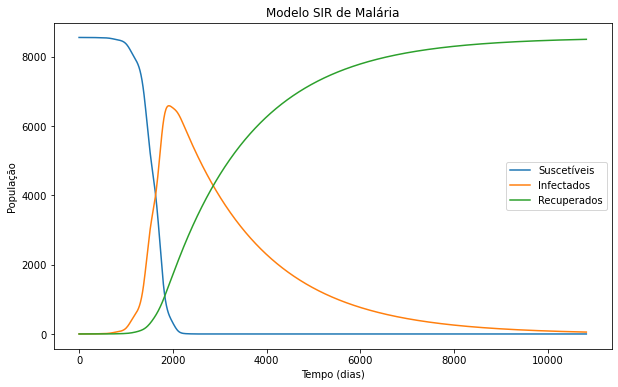

In [95]:
args = (T_linha, T1, T2, omega1, phi1, R1, R2, omega2, phi2,
                   B_E, p_ME, p_ML, p_MP, tau_E, tau_P, c1, c2,
                   D1, 0.04, 317.925, 15, -48.78, 0.09, tau_H, DD, Tmin, gamma, R_L,
                   N, M, E_M0, I_H0, I_M0)

t_eval = np.linspace(0, 10825, 1000)  # Avalia a solução em 1000 pontos entre 0 e 10825
sol = solve_ivp(model, [0, 10825], [N-1, 1, 0, M-1, 1, 0], args=args, dense_output=True, t_eval=t_eval, method="DOP853")
#sol

times = sol.t
S_H, I_H, R_H, S_M, E_M, I_M = sol.y

plt.figure(figsize=(10, 6))
plt.plot(times, S_H, label='Suscetíveis')
plt.plot(times, I_H, label='Infectados')
plt.plot(times, R_H, label='Recuperados')

plt.xlabel('Tempo (dias)')
plt.ylabel('População')
plt.title('Modelo SIR de Malária')

plt.legend()

plt.show()

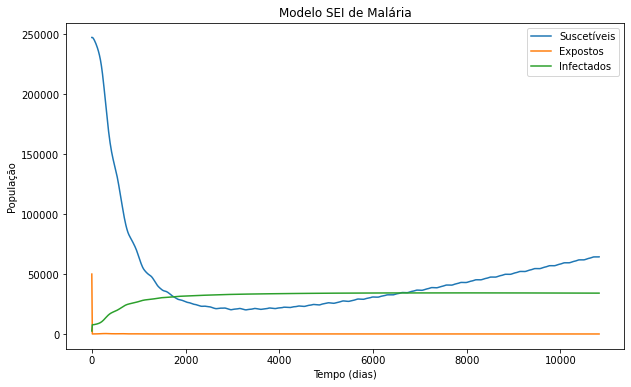

In [96]:
t_eval = np.linspace(0, 10825, 1000)  # Avalia a solução em 1000 pontos entre 0 e 10825
sol = solve_ivp(model, [0, 10825], [N, 0, 0, S_M0, E_M0, I_M0], args=args, dense_output=True, t_eval=t_eval, method="DOP853")
#sol

times = sol.t
S_H, I_H, R_H, S_M, E_M, I_M = sol.y

plt.figure(figsize=(10, 6))
plt.plot(times, S_M, label='Suscetíveis')
plt.plot(times, E_M, label='Expostos')
plt.plot(times, I_M, label='Infectados')

plt.xlabel('Tempo (dias)')
plt.ylabel('População')
plt.title('Modelo SEI de Malária')

plt.legend()

plt.show()

In [97]:
initial_R0_sir, initial_R0_sei, initial_R0_full, a0 = calculate_initial_values(R_L, 25.6, Tmin, DD, 36.5, 
                                                                           T1, T2, omega1, phi1, R1, R2, omega2, phi2,
                                                                           p_ML, p_ME, p_MP, c1, c2, 15, 15, -48.78, 0.1, 0.2, 1/365)

In [98]:
print(f'R0_sir = {initial_R0_sir} \nR0_sei = {initial_R0_sei}\nR0_acoplado = {initial_R0_full}\nTaxa de picadas = {a0}')

R0_sir = 1.7590636555649228 
R0_sei = 2.683074816425812
R0_acoplado = 2.172486914744522
Taxa de picadas = 0.02409676240499894


In [99]:
initial_R0_sir, initial_R0_sei, initial_R0_full, a0 = calculate_initial_values(R_L, 25.6, Tmin, DD, 36.5, 
                                                                           T1, T2, omega1, phi1, R1, R2, omega2, phi2,
                                                                           p_ML, p_ME, p_MP, c1, c2, 15, 15, -48.78, 0.04, 0.09, 1/365)

In [100]:
print(f'R0_sir = {initial_R0_sir} \nR0_sei = {initial_R0_sei}\nR0_acoplado = {initial_R0_full}\nTaxa de picadas = {a0}')

R0_sir = 0.7915786450042152 
R0_sei = 1.0732299265703247
R0_acoplado = 0.9217081376729355
Taxa de picadas = 0.02409676240499894


In [101]:
initial_R0_sir, initial_R0_sei, initial_R0_full, a0 = calculate_initial_values(R_L, 25.6, Tmin, DD, 28, 
                                                                           T1, T2, omega1, phi1, R1, R2, omega2, phi2,
                                                                           p_ML, p_ME, p_MP, c1, c2, 15, 15, -48.78, 0.04, 0.09, 1/365)

In [102]:
print(f'R0_sir = {initial_R0_sir} \nR0_sei = {initial_R0_sei}\nR0_acoplado = {initial_R0_full}\nTaxa de picadas = {a0}')

R0_sir = 1.0318793050947805 
R0_sei = 1.3990318685648873
R0_acoplado = 1.2015123937522194
Taxa de picadas = 0.03141185099223076


In [103]:
initial_R0_sir, initial_R0_sei, initial_R0_full, a0 = calculate_initial_values(R_L, 25.6, Tmin, DD, 36.5, 
                                                                           T1, T2, omega1, phi1, R1, R2, omega2, phi2,
                                                                           p_ML, p_ME, p_MP, c1, c2, 15, 15, -48.78, 0.06, 0.12, 1/365)

In [104]:
print(f'R0_sir = {initial_R0_sir} \nR0_sei = {initial_R0_sei}\nR0_acoplado = {initial_R0_full}\nTaxa de picadas = {a0}')

R0_sir = 1.0554381933389536 
R0_sei = 1.609844889855487
R0_acoplado = 1.3034921488467133
Taxa de picadas = 0.02409676240499894


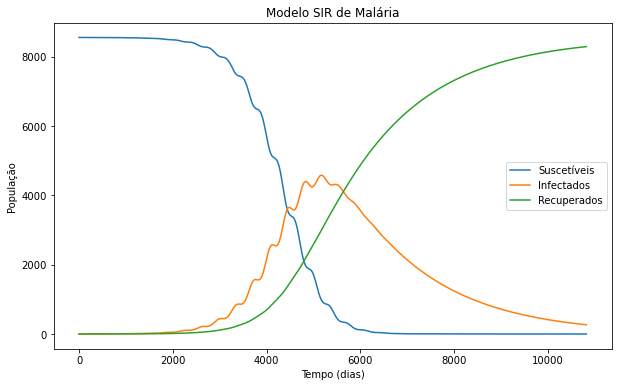

In [105]:
args = (25.6, T1, T2, omega1, phi1, R1, R2, omega2, phi2,
                   B_E, p_ME, p_ML, p_MP, tau_E, tau_P, c1, c2,
                   36.5, 0.04, 15, 15, -48.78, 0.09, tau_H, DD, Tmin, gamma, R_L,
                   N, M, 1, 1, 1)

t_eval = np.linspace(0, 10825, 1000)  # Avalia a solução em 1000 pontos entre 0 e 10825
sol = solve_ivp(model, [0, 10825], [N-1, 1, 0, M-2, 1, 1], args=args, dense_output=True, t_eval=t_eval, method="DOP853")
#sol

times = sol.t
S_H, I_H, R_H, S_M, E_M, I_M = sol.y

plt.figure(figsize=(10, 6))
plt.plot(times, S_H, label='Suscetíveis')
plt.plot(times, I_H, label='Infectados')
plt.plot(times, R_H, label='Recuperados')

plt.xlabel('Tempo (dias)')
plt.ylabel('População')
plt.title('Modelo SIR de Malária')

plt.legend()

plt.show()

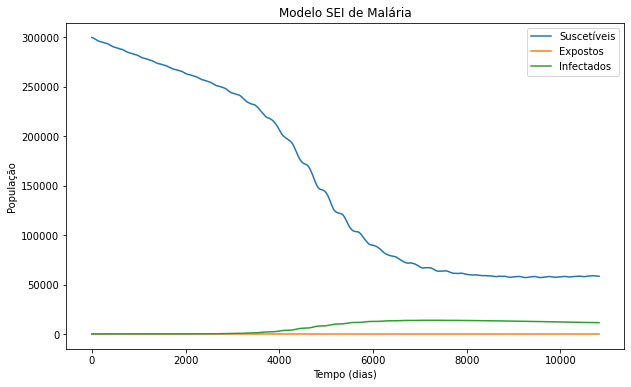

In [106]:
t_eval = np.linspace(0, 10825, 1000)  # Avalia a solução em 1000 pontos entre 0 e 10825
sol = solve_ivp(model, [0, 10825], [N-1, 1, 0, M-2, 1, 1], args=args, dense_output=True, t_eval=t_eval, method="DOP853")
#sol

times = sol.t
S_H, I_H, R_H, S_M, E_M, I_M = sol.y

plt.figure(figsize=(10, 6))
plt.plot(times, S_M, label='Suscetíveis')
plt.plot(times, E_M, label='Expostos')
plt.plot(times, I_M, label='Infectados')

plt.xlabel('Tempo (dias)')
plt.ylabel('População')
plt.title('Modelo SEI de Malária')

plt.legend()

plt.show()

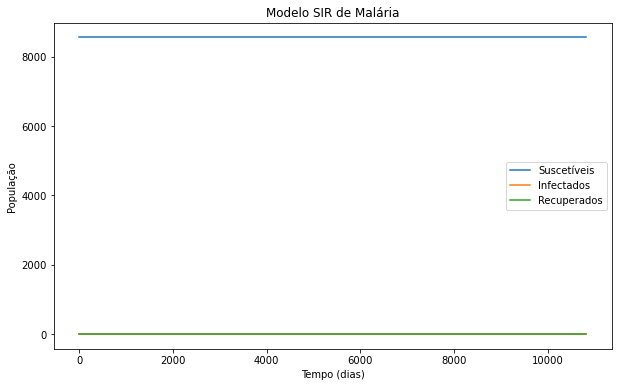

In [107]:
args = (25.6, T1, T2, omega1, phi1, R1, R2, omega2, phi2,
                   B_E, p_ME, p_ML, p_MP, tau_E, tau_P, c1, c2,
                   36.5, 0.04, 15, 15, -48.78, 0.09, tau_H, DD, Tmin, gamma, R_L,
                   N, M, 0, 0, 0)

t_eval = np.linspace(0, 10825, 1000)  # Avalia a solução em 1000 pontos entre 0 e 10825
sol = solve_ivp(model, [0, 10825], [N, 0, 0, M, 0, 0], args=args, dense_output=True, t_eval=t_eval, method="DOP853")
#sol

times = sol.t
S_H, I_H, R_H, S_M, E_M, I_M = sol.y

plt.figure(figsize=(10, 6))
plt.plot(times, S_H, label='Suscetíveis')
plt.plot(times, I_H, label='Infectados')
plt.plot(times, R_H, label='Recuperados')

plt.xlabel('Tempo (dias)')
plt.ylabel('População')
plt.title('Modelo SIR de Malária')

plt.legend()

plt.show()

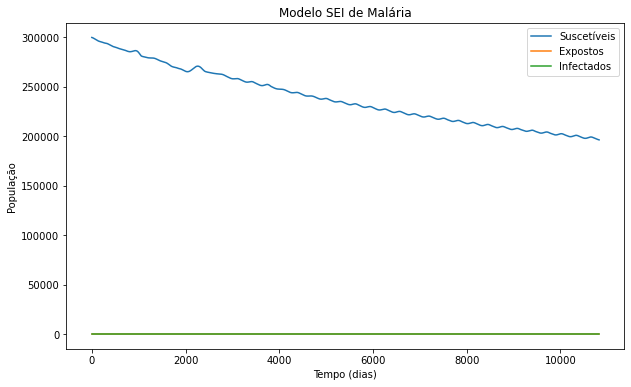

In [108]:
t_eval = np.linspace(0, 10825, 1000)  # Avalia a solução em 1000 pontos entre 0 e 10825
sol = solve_ivp(model, [0, 10825], [N, 0, 0, M, 0, 0], args=args, dense_output=True, t_eval=t_eval, method="DOP853")
#sol

times = sol.t
S_H, I_H, R_H, S_M, E_M, I_M = sol.y

plt.figure(figsize=(10, 6))
plt.plot(times, S_M, label='Suscetíveis')
plt.plot(times, E_M, label='Expostos')
plt.plot(times, I_M, label='Infectados')

plt.xlabel('Tempo (dias)')
plt.ylabel('População')
plt.title('Modelo SEI de Malária')

plt.legend()

plt.show()